<a href="https://colab.research.google.com/github/RealGoldenGeneral/mini-project-5/blob/main/cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mini Project 5 - Satellite Image Classification
### Contributors: Sepehr Mansouri & Nicky Cheng

### Data Exploration & Preprocessing

In [44]:
# ============================================================
# Imports and setup
# ============================================================
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import random
import numpy as np
# Verify versions
print(f"TensorFlow version: {tf.__version__}")
# print(f"NumPy version:      {np.__version__}")''


"""Option E: Satellite Image Classification
Source: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
Description: 4 classes (cloudy, desert, green area, water)
Challenge: Satellite perspective, environmental variation
Good for: Students interested in remote sensing and environmental monitoring"""

# Import the images from form the ../data directory
# it has cloudy, desert, green area, water folders
data_dir = "../data/"
# Get class names from the directory structure as List
class_names = os.listdir(data_dir)
print(f"Classes: {class_names}")
# Setting random seed for reproducibility
random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Plot settings
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Load image paths and labels
image_paths = []
labels = []
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)


# Check class distribution
from collections import Counter
class_counts = Counter(labels)
print(f"Class distribution: {class_counts}")


TensorFlow version: 2.20.0
Classes: ['cloudy', 'desert', 'green_area', 'water']
Class distribution: Counter({'cloudy': 1500, 'green_area': 1500, 'water': 1500, 'desert': 1131})


In [45]:
# Data Directory Setup & Validation

# Check if data exists locally
data_dir = "../data/"

if not os.path.exists(data_dir):
    raise FileNotFoundError(f"- Data directory not found at {os.path.abspath(data_dir)}")

if len(os.listdir(data_dir)) == 0:
    raise FileNotFoundError(f"- Data directory is empty: {os.path.abspath(data_dir)}")

print(f"- Path: {os.path.abspath(data_dir)}")

# Validate data structure
print("\n- Class folders in data directory:")
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    image_count = len([f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    print(f"   - {class_name}: {image_count} images")

if not class_names:
    raise FileNotFoundError(f"- No class folders found in {data_dir}")

print(f"\n- Data validation passed! Found {len(class_names)} classes")


- Path: c:\Users\Sepeh\source\repos\mini-project-5\data

- Class folders in data directory:
   - cloudy: 1500 images
   - desert: 1131 images
   - green_area: 1500 images
   - water: 1500 images

- Data validation passed! Found 4 classes


In [46]:
# Load images into TensorFlow datasets
IMG_SIZE = 250  # Original resolution (250x250)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Using 'categorical' for multi-class (4 classes)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print(f" Datasets loaded successfully!")
print(f"Class names: {class_names}")
print(f"Training batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")


Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.
 Datasets loaded successfully!
Class names: ['cloudy', 'desert', 'green_area', 'water']
Training batches: 141
Validation batches: 36


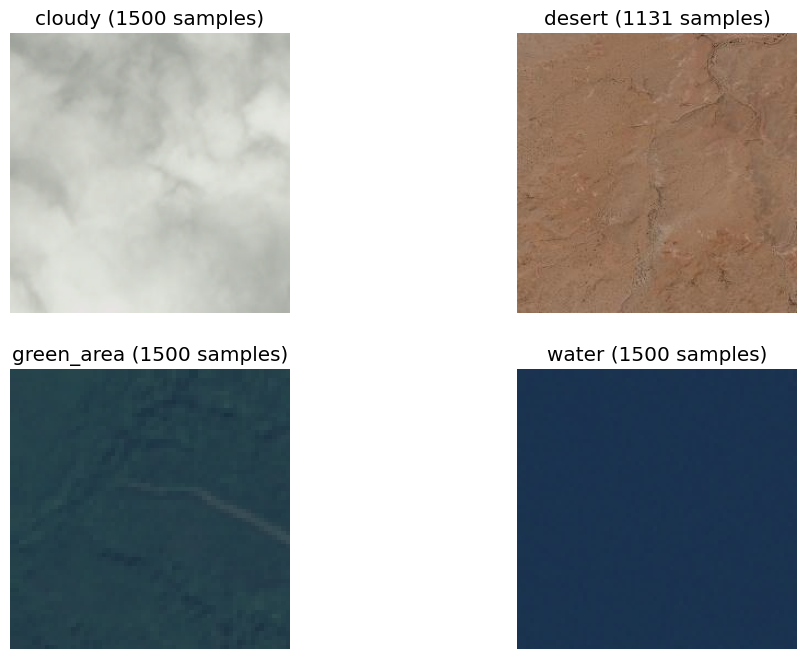

In [47]:
# Displaying images from each class
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    class_images = [img for img, label in zip(image_paths, labels) if label == class_name]
    sample_image = random.choice(class_images)
    img = plt.imread(sample_image)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"{class_name} ({class_counts[class_name]} samples)")
    plt.axis('off')

### Baseline CNN (No Augmentation)

In [48]:
# Baseline CNN (No Augmentation)
# Custom CNN architecture (minimum 3 Conv blocks)

model_baseline = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Classification Head to Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

# Display model architecture
model_baseline.summary()



c:\Users\Sepeh\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    13,779,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,872,836 (52.92 MB)

 Trainable params: 13,872,836 (52.92 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Compiliong the model


model_baseline.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n- Model compiled successfully!")
print("- Optimizer: Adam")
print("- Loss: Binary Crossentropy")
print("- Metrics: Accuracy")


- Model compiled successfully!
- Optimizer: Adam
- Loss: Binary Crossentropy
- Metrics: Accuracy


In [50]:
# Training the model

EPOCHS = 25
history_baseline = model_baseline.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 27s 185ms/step - accuracy: 0.8424 - loss: 0.3304 - val_accuracy: 0.8544 - val_loss: 0.3697
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.9079 - loss: 0.2002 - val_accuracy: 0.8881 - val_loss: 0.2307
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.9112 - loss: 0.2078 - val_accuracy: 0.8668 - val_loss: 0.2475
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.9205 - loss: 0.1764 - val_accuracy: 0.9245 - val_loss: 0.1752
Epoch 5/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.9272 - loss: 0.1647 - val_accuracy: 0.9263 - val_loss: 0.1506
Epoch 6/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.9356 - loss: 0.1484 - val_accuracy: 0.9423 - val_loss: 0.1549
Epoch 7/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.9241 - loss: 0.1659 - val_accuracy: 0.9298 - val_loss: 0.1404
Epoch 8/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.9303 - loss: 0

In [51]:
#  Helper function for plotting training curves (accuracy and loss)


def plot_training_curves(history, title='Model Training'):
    """Plot accuracy and loss curves for training and validation."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title(f'{title} — Accuracy', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0.4, 1.05])

    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title(f'{title} — Loss', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc
    print(f"\n- Final Results:")
    print(f"   Train Accuracy:      {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
    print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
    print(f"   Gap (overfit check): {gap:.4f} ({gap*100:.1f}%)")
    if gap > 0.15:
        print(f"   -  Large gap — model is OVERFITTING")
    elif gap > 0.05:
        print(f"   - Moderate gap — some overfitting")
    else:
        print(f"   - Small gap — good generalization!")


def show_predictions(model, dataset, class_names, n=10):
    plt.figure(figsize=(16, 4))
    for images, labels in dataset.take(1):
        predictions = model.predict(images, verbose=0)
        for i in range(min(n, len(images))):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))

            # prediction: softmax vector -> choose top class
            pred_probs = predictions[i]
            pred_label = int(np.argmax(pred_probs))
            pred_prob = float(pred_probs[pred_label])

            # true label: handle one-hot or integer labels
            true = labels[i].numpy()
            if true.ndim > 0:
                true_label = int(np.argmax(true))
            else:
                true_label = int(true)

            color = 'green' if pred_label == true_label else 'red'
            plt.title(
                f'Pred: {class_names[pred_label]}\n({pred_prob:.2f})\nTrue: {class_names[true_label]}',
                fontsize=9, color=color, fontweight='bold'
            )
            plt.axis('off')

    plt.suptitle('Predictions (Green=Correct, Red=Wrong)', fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Helper functions loaded")

Helper functions loaded


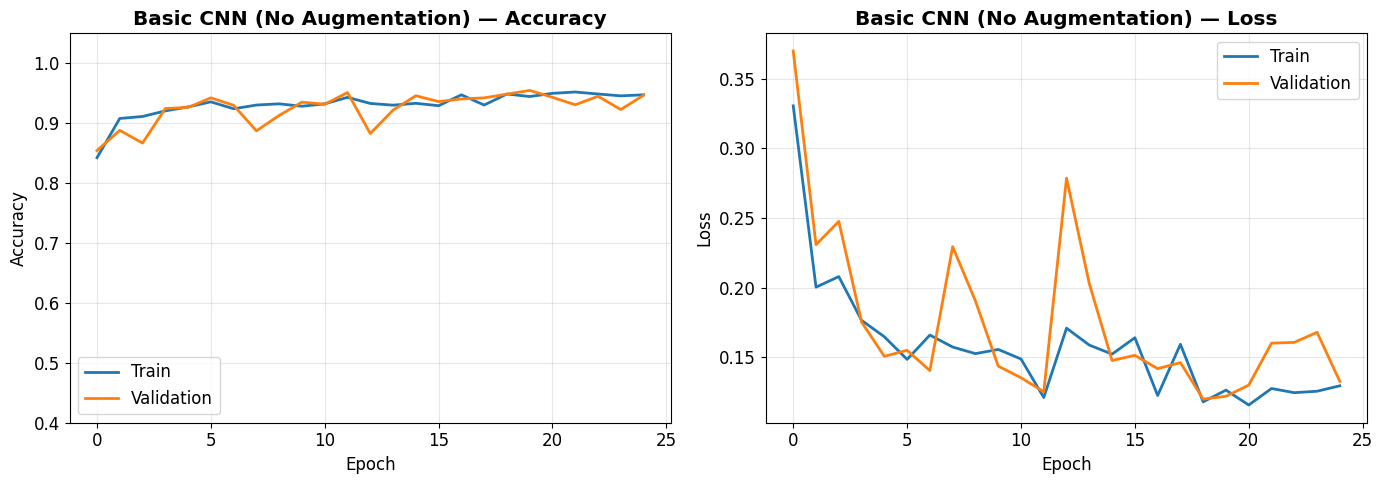


- Final Results:
   Train Accuracy:      0.9474 (94.7%)
   Validation Accuracy: 0.9467 (94.7%)
   Gap (overfit check): 0.0007 (0.1%)
   - Small gap — good generalization!


In [52]:
# Plotting the training curves
plot_training_curves(history_baseline, title='Basic CNN (No Augmentation)')

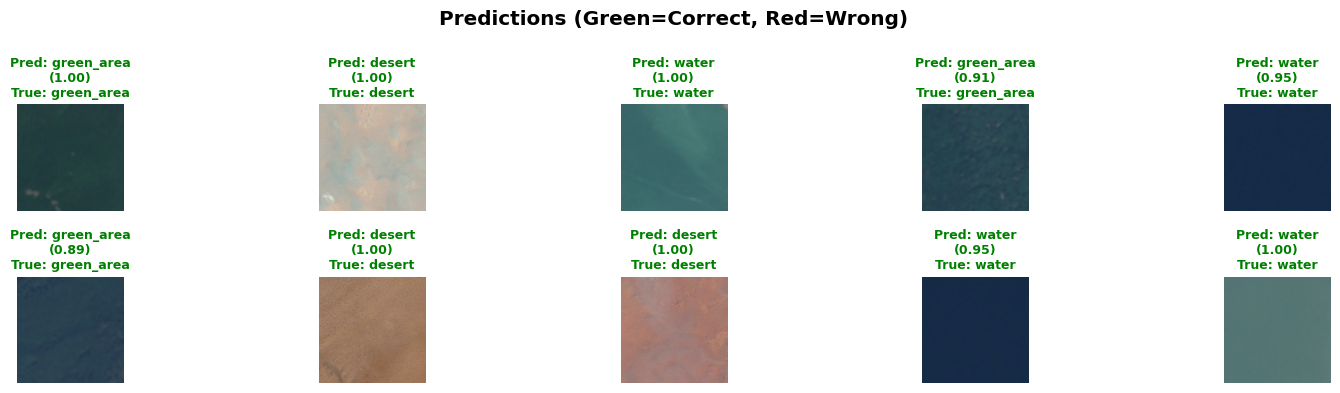

In [53]:
# Showing Predictions
show_predictions(model_baseline, val_ds, class_names)


In [54]:
# Reporting accuracy, precision, recall, and F1-score
from sklearn.metrics import classification_report, confusion_matrix
# Get true labels and predicted labels for validation set
y_true_base = []
y_pred_base = []
for images, labels in val_ds:
    preds = model_baseline.predict(images, verbose=0)
    y_true_base.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_base.extend(np.argmax(preds, axis=1))
print("\nClassification Report (Baseline Model):")
print(classification_report(y_true_base, y_pred_base, target_names=class_names))
print("Confusion Matrix:")
print(confusion_matrix(y_true_base, y_pred_base))


Classification Report (Baseline Model):
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       267
      desert       1.00      1.00      1.00       224
  green_area       0.88      0.95      0.91       318
       water       0.94      0.86      0.90       317

    accuracy                           0.95      1126
   macro avg       0.95      0.95      0.95      1126
weighted avg       0.95      0.95      0.95      1126

Confusion Matrix:
[[267   0   0   0]
 [  0 224   0   0]
 [  0   0 301  17]
 [  0   0  43 274]]


### Improved CNN (With Augmentation)

In [55]:

# Data Augmentation Layers using

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

train_ds_aug = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

for layer in data_augmentation.layers:
    print(f"- {layer.name}: {layer.__class__.__name__}")

- random_flip_4: RandomFlip
- random_rotation_4: RandomRotation
- random_zoom_4: RandomZoom
- random_contrast_4: RandomContrast


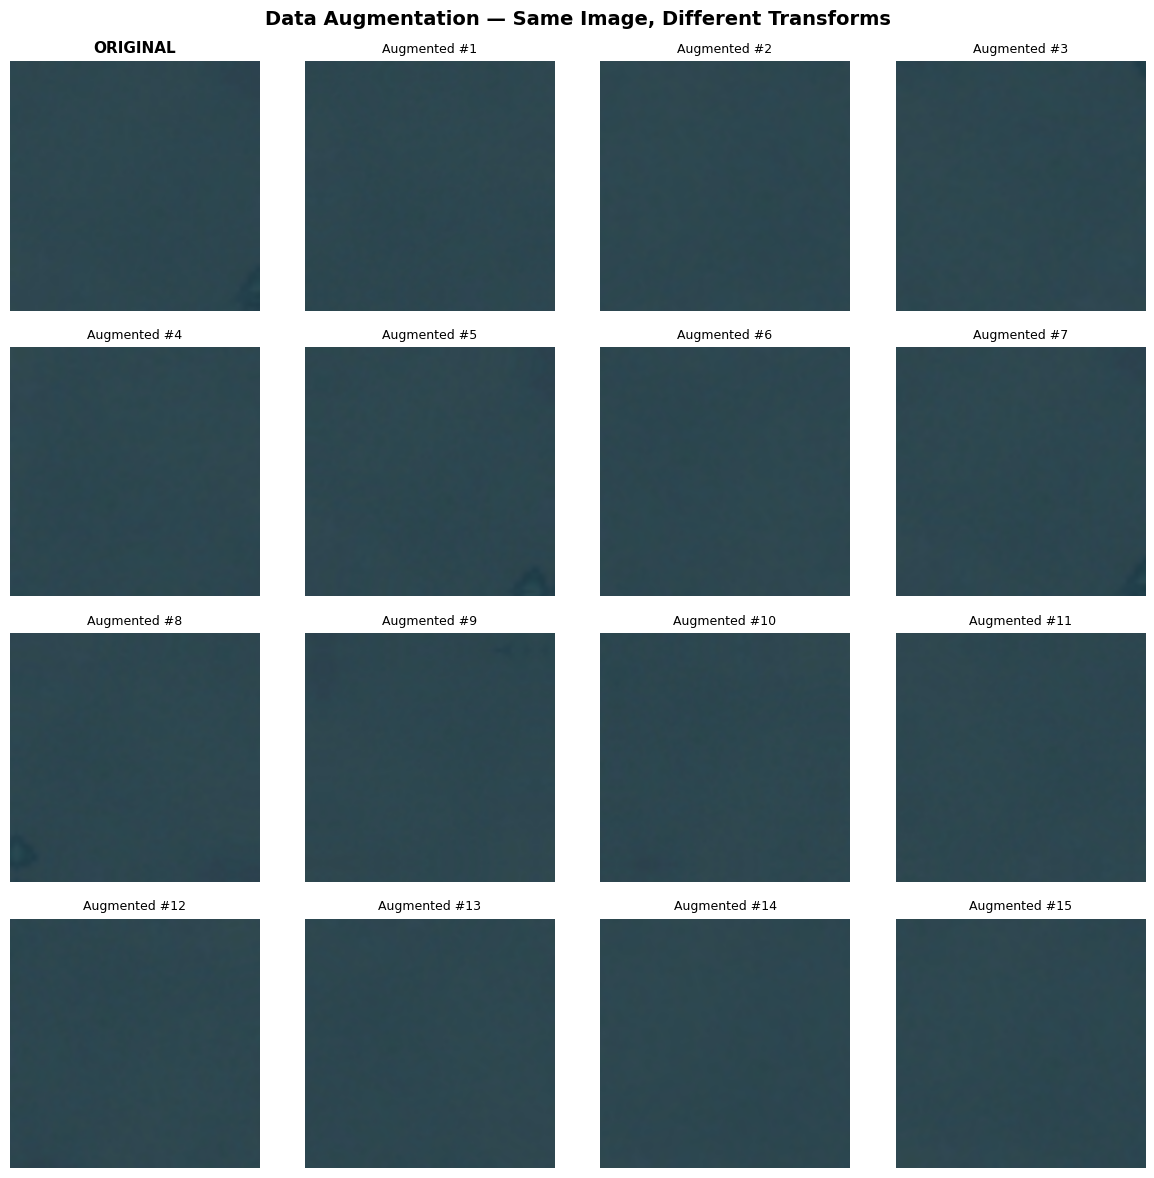

 - Each epoch, the model sees a DIFFERENT version of every training image. With augmentation both horizontal and vertical flips are possible!


In [56]:
# Visualize augmentation on a single image
plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
    sample_image = images[0]

    plt.subplot(4, 4, 1)
    plt.imshow(sample_image.numpy().astype('uint8'))
    plt.title('ORIGINAL', fontweight='bold', fontsize=11)
    plt.axis('off')

    for i in range(15):
        augmented = data_augmentation(tf.expand_dims(sample_image, 0), training=True)
        plt.subplot(4, 4, i + 2)
        plt.imshow(augmented[0].numpy().astype('uint8'))
        plt.title(f'Augmented #{i+1}', fontsize=9)
        plt.axis('off')

plt.suptitle('Data Augmentation — Same Image, Different Transforms', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(" - Each epoch, the model sees a DIFFERENT version of every training image. With augmentation both horizontal and vertical flips are possible!")

In [57]:
# Implement at least 3 different augmentation techniques using Keras layers


model_augmented = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model_augmented.summary()

c:\Users\Sepeh\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 248, 248, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 122, 122, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 59, 59, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    13,779,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,873,732 (52.92 MB)

 Trainable params: 13,873,284 (52.92 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Compile and train the augmented model

EPOCHS_AUGMENTED = 25

train_ds_aug = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
) 

model_augmented.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_augmented = model_augmented.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=EPOCHS_AUGMENTED
)

Epoch 1/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.8322 - loss: 5.0822 - val_accuracy: 0.2824 - val_loss: 14.3054
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 68s 483ms/step - accuracy: 0.8539 - loss: 1.9255 - val_accuracy: 0.4378 - val_loss: 61.2224
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 488ms/step - accuracy: 0.8340 - loss: 1.2515 - val_accuracy: 0.6483 - val_loss: 7.3978
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 486ms/step - accuracy: 0.8368 - loss: 0.6994 - val_accuracy: 0.7309 - val_loss: 0.4272
Epoch 5/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 67s 476ms/step - accuracy: 0.8646 - loss: 0.5208 - val_accuracy: 0.7362 - val_loss: 0.6883
Epoch 6/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 68s 478ms/step - accuracy: 0.8726 - loss: 0.3092 - val_accuracy: 0.8890 - val_loss: 0.2560
Epoch 7/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 66s 466ms/step - accuracy: 0.9006 - loss: 0.2770 - val_accuracy: 0.8623 - val_loss: 0.3207
Epoch 8/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 68s 482ms/step - accuracy: 0.8661 - loss:

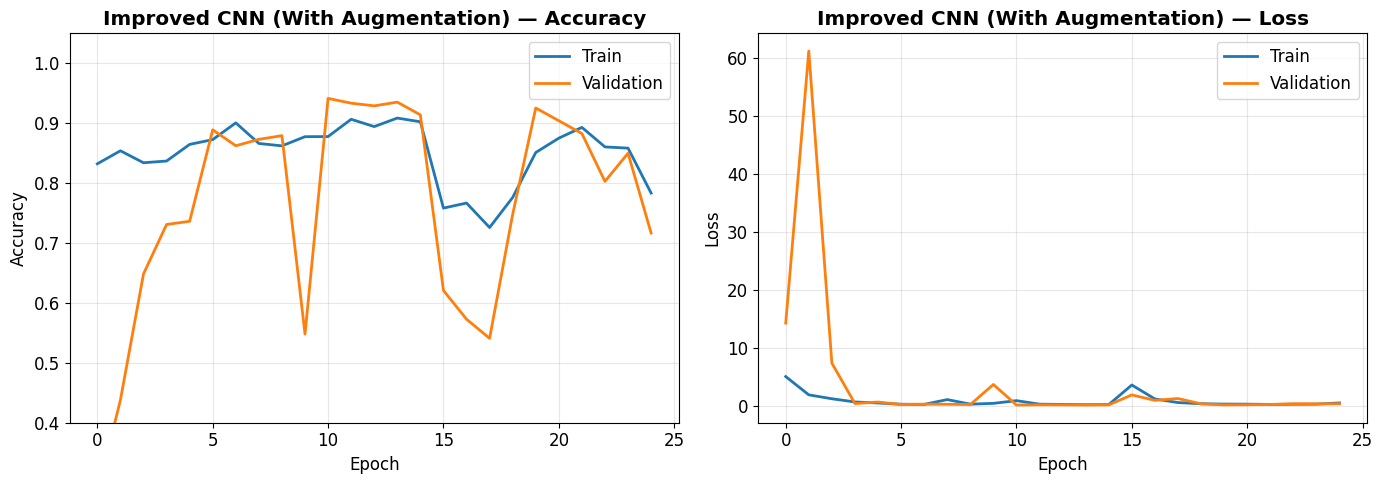


- Final Results:
   Train Accuracy:      0.7834 (78.3%)
   Validation Accuracy: 0.7167 (71.7%)
   Gap (overfit check): 0.0667 (6.7%)
   - Moderate gap — some overfitting


In [70]:
plot_training_curves(history_augmented, title='Improved CNN (With Augmentation)')

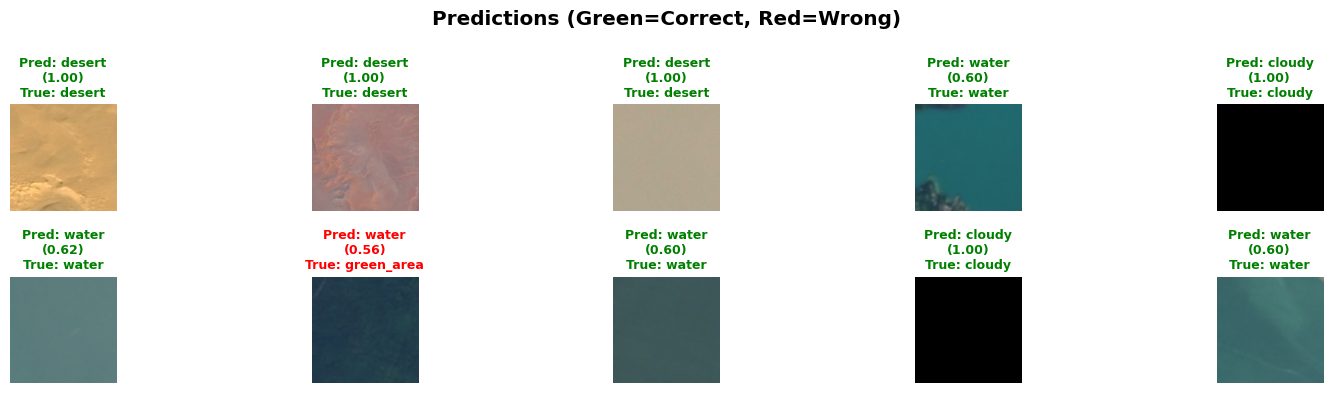

In [71]:
show_predictions(model_augmented, val_ds, class_names)

In [60]:
# Report of accuracy, precision, recall, and F1-score for the augmented model
y_true_aug = []
y_pred_aug = []
for images, labels in val_ds:
    preds = model_augmented.predict(images, verbose=0)
    y_true_aug.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_aug.extend(np.argmax(preds, axis=1))
print("\nClassification Report (Augmented Model):")
print(classification_report(y_true_aug, y_pred_aug, target_names=class_names))
print("Confusion Matrix (Augmented Model):")
print(confusion_matrix(y_true_aug, y_pred_aug))


Classification Report (Augmented Model):
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       267
      desert       1.00      1.00      1.00       224
  green_area       0.00      0.00      0.00       318
       water       0.50      1.00      0.67       317

    accuracy                           0.72      1126
   macro avg       0.62      0.75      0.67      1126
weighted avg       0.58      0.72      0.62      1126

Confusion Matrix (Augmented Model):
[[267   0   0   0]
 [  0 223   0   1]
 [  0   0   0 318]
 [  0   0   0 317]]


c:\Users\Sepeh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sepeh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sepeh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

### Model Comparison & Analysis

In [61]:
# Creating comparison table of baseline vs augmented model (showing accuracy, F1, train-val gap)
from sklearn.metrics import classification_report, f1_score
import pandas as pd

basic_train = history_baseline.history['accuracy'][-1]
basic_val = history_baseline.history['val_accuracy'][-1]
aug_train = history_augmented.history['accuracy'][-1]
aug_val = history_augmented.history['val_accuracy'][-1]
f1_base = f1_score(y_true_base, y_pred_base, average='weighted')
f1_aug  = f1_score(y_true_aug,  y_pred_aug,  average='weighted')

comparison = pd.DataFrame({
    'Model':     ['Basic CNN', 'Augmented CNN'],
    'Train Acc': [f'{basic_train:.4f}', f'{aug_train:.4f}'],
    'Val Acc':   [f'{basic_val:.4f}',   f'{aug_val:.4f}'],
    'F1 Score':  [f'{f1_base:.4f}',     f'{f1_aug:.4f}'],
    'Gap':       [f'{basic_train - basic_val:.4f}', f'{aug_train - aug_val:.4f}']
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison.to_string(index=False))
print("="*60)


MODEL COMPARISON
        Model Train Acc Val Acc F1 Score    Gap
    Basic CNN    0.9474  0.9467   0.9466 0.0007
Augmented CNN    0.7834  0.7167   0.6229 0.0667


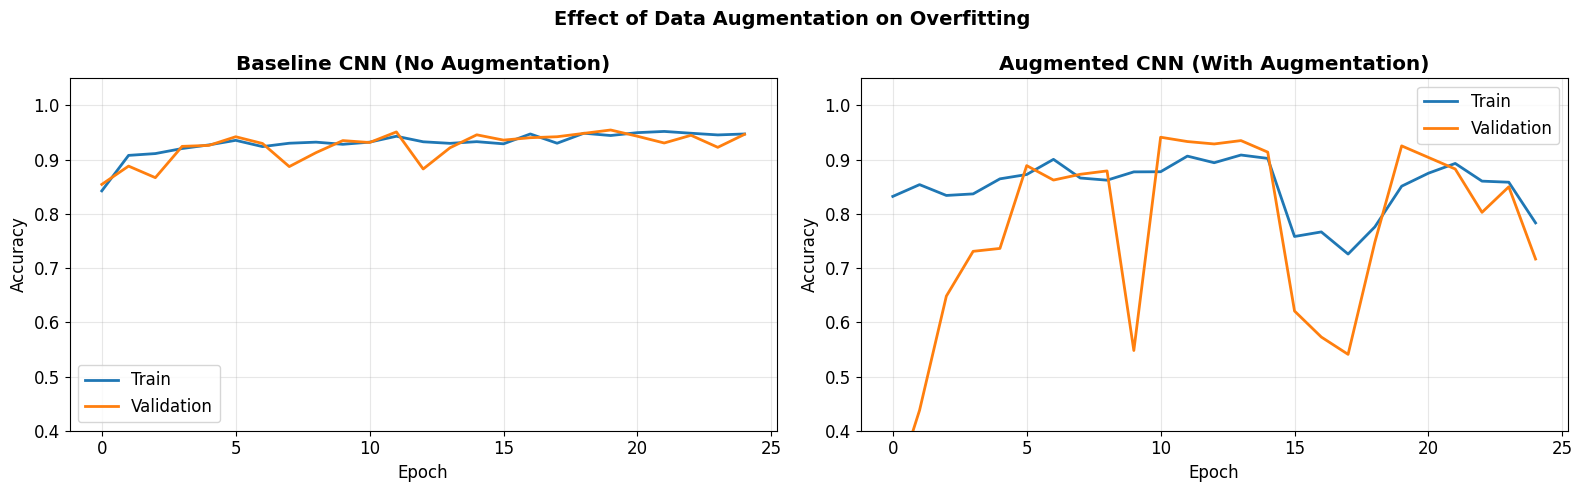

In [62]:
# Plotting train/val accuracy for both models

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(history_baseline.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_baseline.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Baseline CNN (No Augmentation)', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.4, 1.05])


# Right subplot: Augmented CNN
axes[1].plot(history_augmented.history['accuracy'], label='Train', linewidth=2)
axes[1].plot(history_augmented.history['val_accuracy'], label='Validation', linewidth=2)
axes[1].set_title('Augmented CNN (With Augmentation)', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.4, 1.05])

plt.suptitle('Effect of Data Augmentation on Overfitting', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [63]:
# Visualizing at least one of: feature maps, learned filters, or activation heatmaps
inp = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = inp
conv_outputs = []
conv_names = []
for layer in model_baseline.layers:
    x = layer(x)
    if isinstance(layer, layers.Conv2D):
        conv_outputs.append(x)
        conv_names.append(layer.name)
        print(f"  {layer.name}: output shape = {x.shape}")


feature_map_model = models.Model(inputs=inp, outputs=conv_outputs)

  conv2d_12: output shape = (None, 248, 248, 32)
  conv2d_13: output shape = (None, 122, 122, 64)
  conv2d_14: output shape = (None, 59, 59, 128)


Class names: ['cloudy', 'desert', 'green_area', 'water']


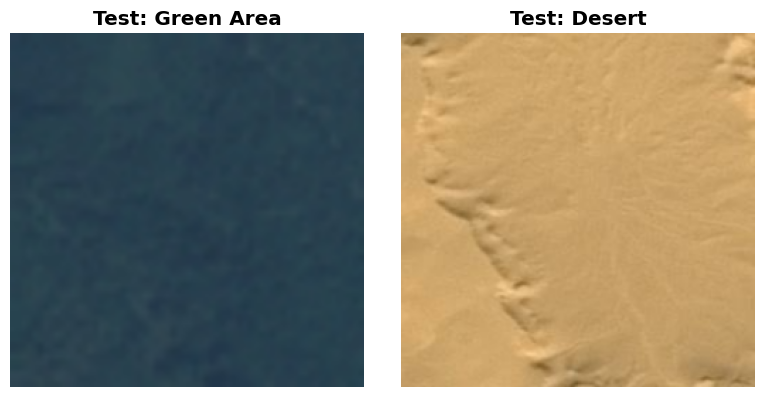

In [64]:
# Select a green_area image and a desert image for comparison
# class_names (alphabetical): ['cloudy', 'desert', 'green_area', 'water']
print("Class names:", class_names)

green_class  = class_names.index('green_area')
desert_class = class_names.index('desert')

for images, labels_batch in val_ds.take(1):
    green_idx  = None
    desert_idx = None
    for i in range(len(labels_batch)):
        label = int(np.argmax(labels_batch[i].numpy()))  # one-hot → int
        if label == green_class and green_idx is None:
            green_idx = i
        elif label == desert_class and desert_idx is None:
            desert_idx = i
        if green_idx is not None and desert_idx is not None:
            break

test_green  = images[green_idx]
test_desert = images[desert_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(test_green.numpy().astype('uint8'))
ax1.set_title('Test: Green Area', fontweight='bold')
ax1.axis('off')
ax2.imshow(test_desert.numpy().astype('uint8'))
ax2.set_title('Test: Desert', fontweight='bold')
ax2.axis('off')
plt.tight_layout()
plt.show()

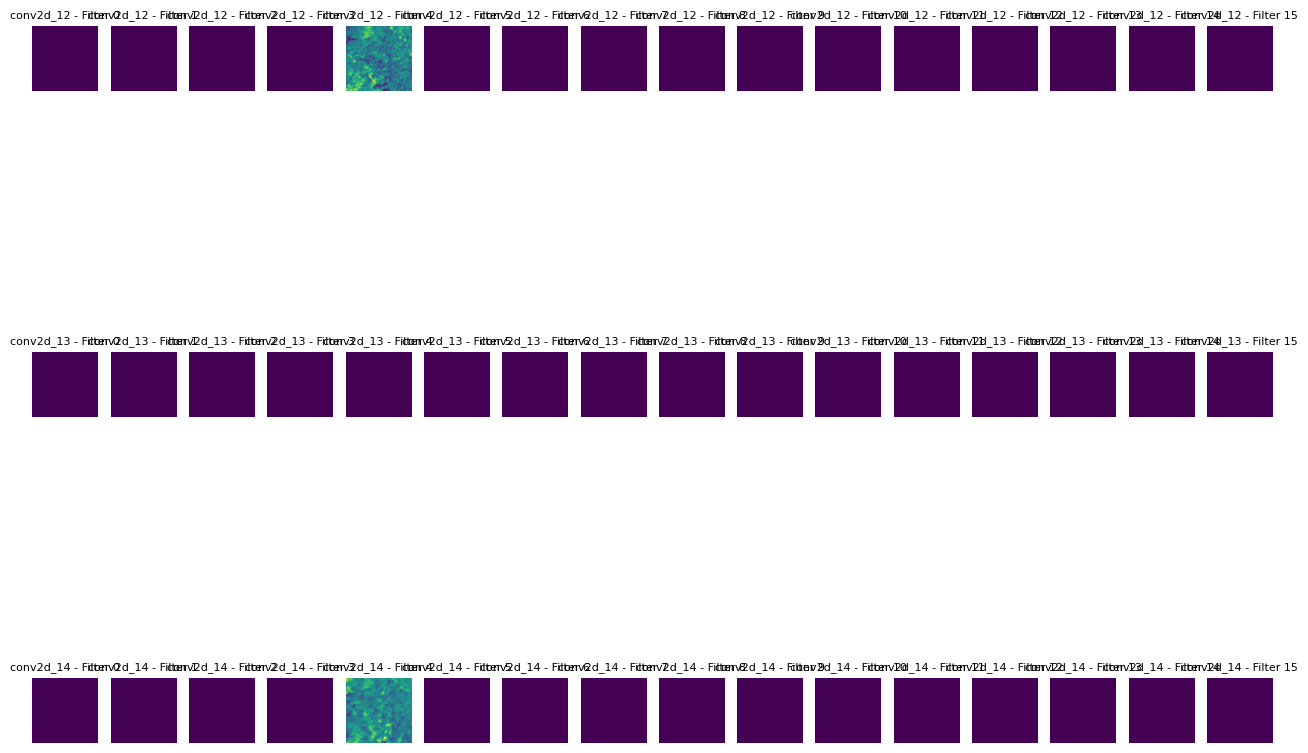

In [65]:
# Getting feature maps for image and display them

test_input = tf.expand_dims(test_green, 0)
feature_maps = feature_map_model.predict(test_input, verbose=0)

# conv_names was defined in the cell above
conv_names = [layer.name for layer in model_baseline.layers if isinstance(layer, layers.Conv2D)]

# displaying feature maps for each layer
plt.figure(figsize=(16, 4 * len(feature_maps)))
for layer_idx, feature_map in enumerate(feature_maps):
    num_filters = feature_map.shape[-1]
    for filter_idx in range(min(16, num_filters)):
        plt.subplot(len(feature_maps), 16, layer_idx * 16 + filter_idx + 1)
        plt.imshow(feature_map[0, :, :, filter_idx], cmap='viridis')
        plt.title(f"{conv_names[layer_idx]} - Filter {filter_idx}", fontsize=8)
        plt.axis('off')


Layer: conv2d_12, Filter shape: (3, 3, 3, 32)

Layer: conv2d_13, Filter shape: (3, 3, 32, 64)

Layer: conv2d_14, Filter shape: (3, 3, 64, 128)


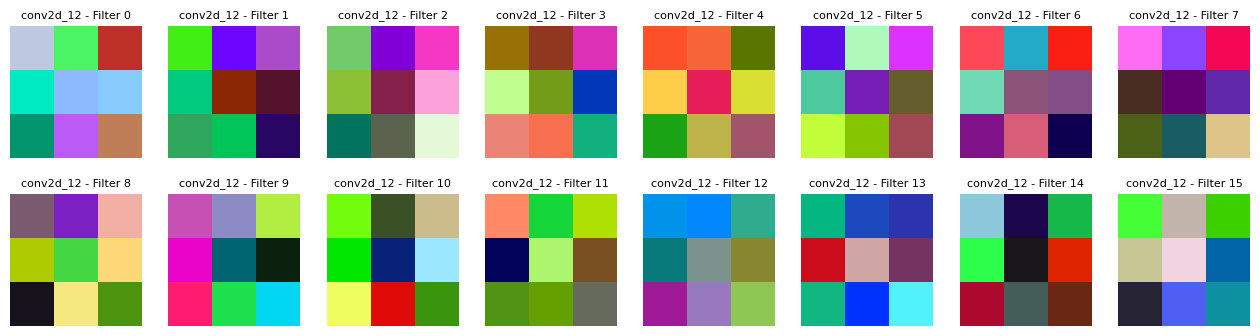

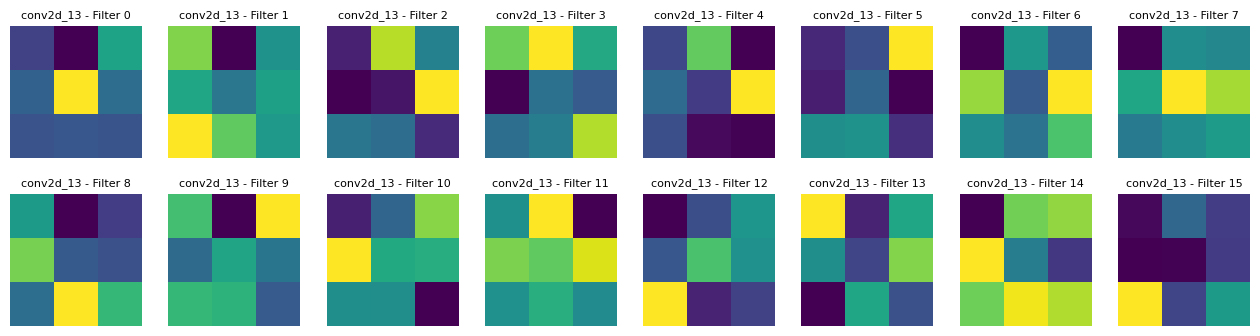

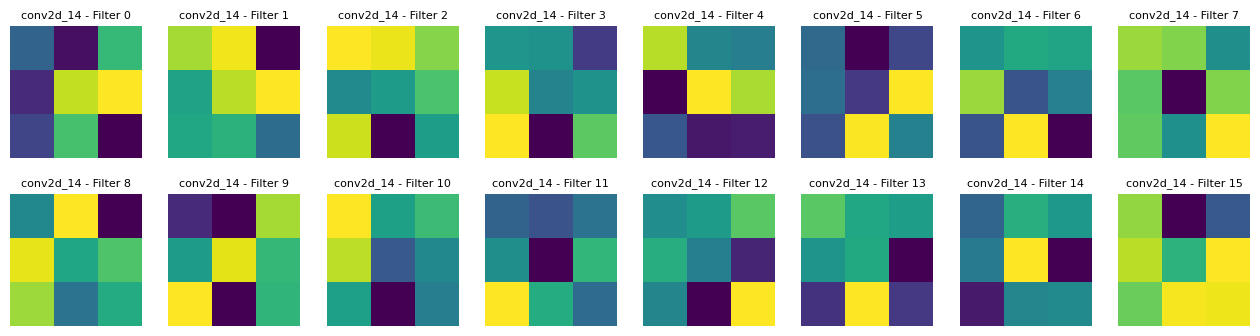

In [66]:
# Visualizing learned filters for each Conv2D layer
for layer in model_baseline.layers:
    if isinstance(layer, layers.Conv2D):
        filters, biases = layer.get_weights()
        print(f"\nLayer: {layer.name}, Filter shape: {filters.shape}")
    
        num_filters = filters.shape[-1]
        plt.figure(figsize=(16, 4))
        for filter_idx in range(min(16, num_filters)):
            f = filters[:, :, :, filter_idx]
            if f.shape[2] == 3:
                # First layer: display as RGB
                f_min, f_max = f.min(), f.max()
                f_norm = (f - f_min) / (f_max - f_min + 1e-5)
                plt.subplot(2, 8, filter_idx + 1)
                plt.imshow(f_norm)
                plt.title(f"{layer.name} - Filter {filter_idx}", fontsize=8)
                plt.axis('off')
            else:
                # Deeper layers: show mean across input channels
                f_mean = np.mean(f, axis=-1)
                f_min, f_max = f_mean.min(), f_mean.max()
                f_norm = (f_mean - f_min) / (f_max - f_min + 1e-5)
                plt.subplot(2, 8, filter_idx + 1)
                plt.imshow(f_norm, cmap='viridis')
                plt.title(f"{layer.name} - Filter {filter_idx}", fontsize=8)
                plt.axis('off')

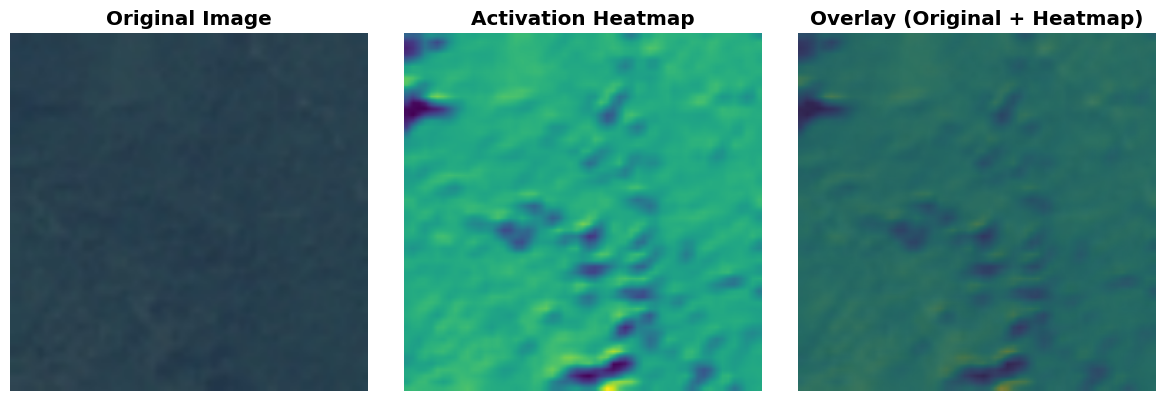

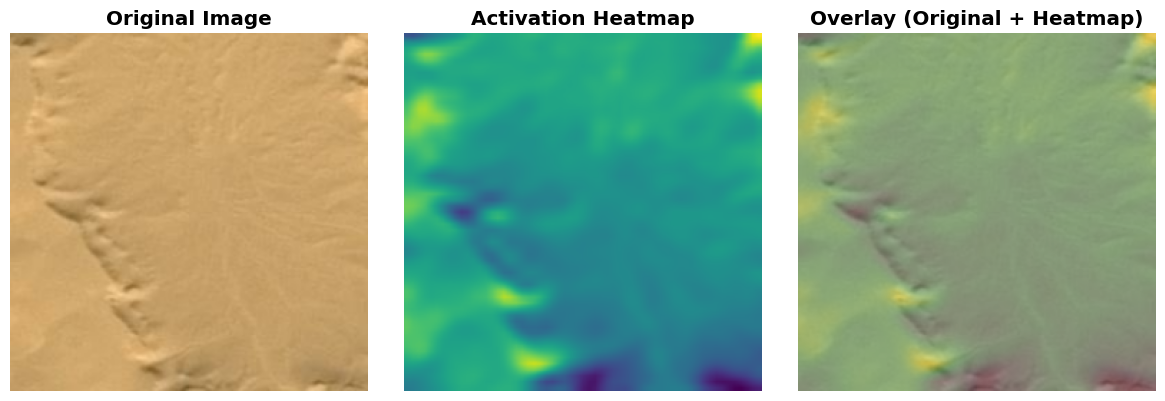

In [67]:
#  Activation heatmap

fmaps_green = feature_map_model.predict(tf.expand_dims(test_green, 0), verbose=0)
fmaps_desert = feature_map_model.predict(tf.expand_dims(test_desert, 0), verbose=0)

# Get last layer's feature maps
fmaps_last = fmaps_green[-1]  # shape: (1, H, W, 128)

heatmap = np.mean(fmaps_last[0], axis=-1)  # Average across filters
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-5)  # Normalize to [0, 1]

heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (IMG_SIZE, IMG_SIZE)).numpy().squeeze()
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(test_green.numpy().astype('uint8'))
plt.title('Original Image', fontweight='bold')
plt.axis('off') 
plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap='viridis')
plt.title('Activation Heatmap', fontweight='bold')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(test_green.numpy().astype('uint8'))
plt.imshow(heatmap_resized, cmap='viridis', alpha=0.4)
plt.title('Overlay (Original + Heatmap)', fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


heatmap_desert = np.mean(fmaps_desert[-1][0], axis=-1)
heatmap_desert = (heatmap_desert - heatmap_desert.min()) / (heatmap_desert.max() - heatmap_desert.min() + 1e-5)
heatmap_desert_resized = tf.image.resize(heatmap_desert[..., np.newaxis], (IMG_SIZE, IMG_SIZE)).numpy().squeeze()
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(test_desert.numpy().astype('uint8'))
plt.title('Original Image', fontweight='bold')
plt.axis('off') 
plt.subplot(1, 3, 2)
plt.imshow(heatmap_desert_resized, cmap='viridis')
plt.title('Activation Heatmap', fontweight='bold')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(test_desert.numpy().astype('uint8'))
plt.imshow(heatmap_desert_resized, cmap='viridis', alpha=0.4)
plt.title('Overlay (Original + Heatmap)', fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


Misclassified count: 319 out of 1126 (28.3%)


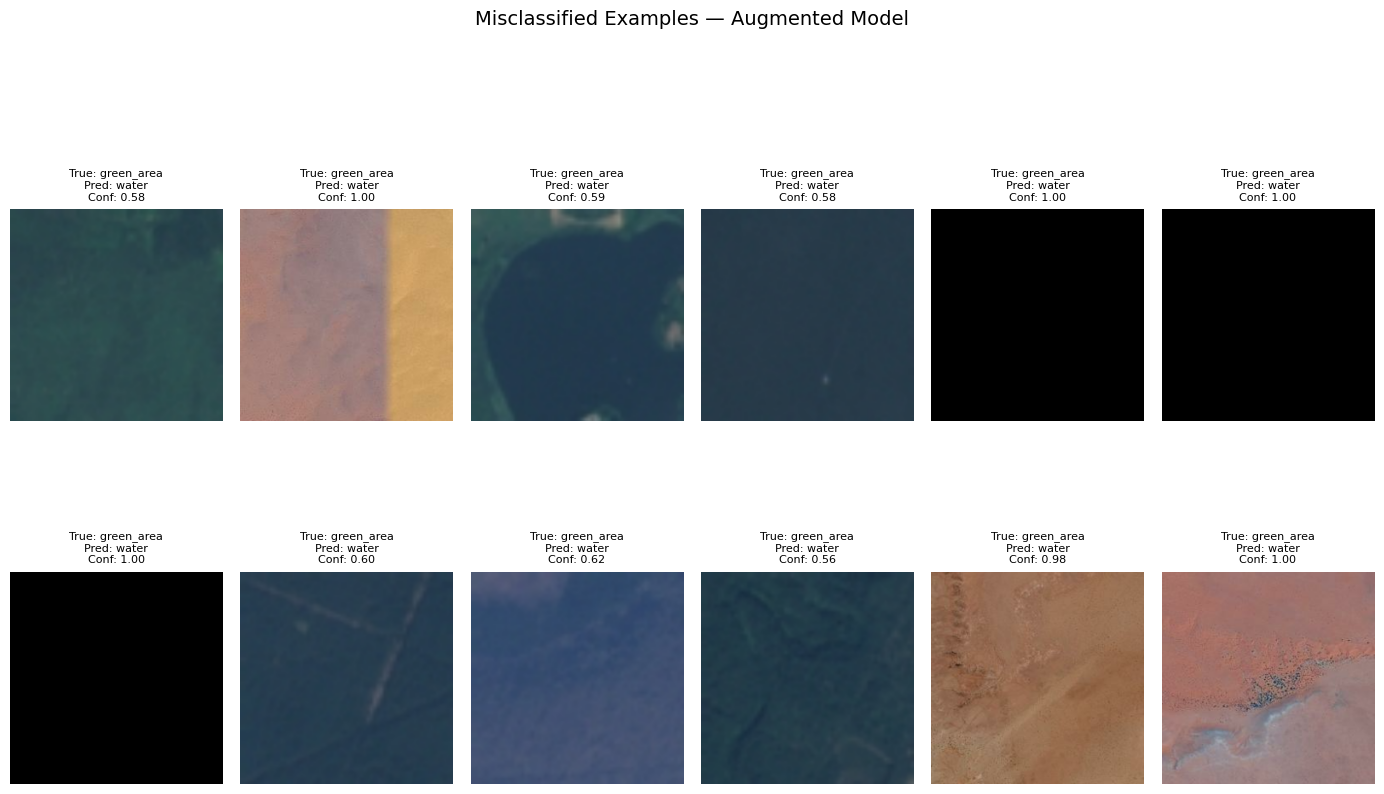

In [68]:
# Misclassified Image Analysis — Augmented Model
import math

y_true = np.array(y_true_aug)
y_pred = np.array(y_pred_aug)

# Find misclassified examples
mis_idx = np.where(y_true != y_pred)[0]
print(f"Misclassified count: {len(mis_idx)} out of {len(y_true)} ({len(mis_idx)/len(y_true)*100:.1f}%)")

# Randomly select up to 12 examples
k = min(12, len(mis_idx))
np.random.shuffle(mis_idx)
chosen = mis_idx[:k]

# Collect all validation images and their prediction confidences
all_images = []
all_probs  = []

for images, labels_batch in val_ds:
    preds = model_augmented.predict(images, verbose=0)
    all_images.extend([img.numpy().astype('uint8') for img in images])
    all_probs.extend(preds)

all_images = np.array(all_images)
all_probs  = np.array(all_probs)

# Plot misclassified examples
cols = 6
rows = math.ceil(k / cols)
plt.figure(figsize=(14, 4.5 * rows))

for i, idx in enumerate(chosen, start=1):
    img        = all_images[idx]
    true_label = y_true[idx]
    pred_label = y_pred[idx]
    conf       = float(all_probs[idx].max())

    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {conf:.2f}",
        fontsize=8
    )

plt.suptitle('Misclassified Examples — Augmented Model', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [69]:
"""Model Comparison & Analysis
# 
# Visualize at least one of: feature maps, learned filters, or activation heatmaps
# plotting train/val accuracy for both models
Analyze misclassified images — what patterns does the model struggle with?
Discuss: What would you try next to improve performance?
"""

'Model Comparison & Analysis\n# \n# Visualize at least one of: feature maps, learned filters, or activation heatmaps\n# plotting train/val accuracy for both models\nAnalyze misclassified images — what patterns does the model struggle with?\nDiscuss: What would you try next to improve performance?\n'

### CNN Architecture Experiment (Bonus)